This Jupyter notebook demonstrates techniques for predicting the antimicrobial activity of peptides.\
\
The data used in this analysis is sourced from [data source](https://cbbio.online/AxPEP/?action=dataset), and preprocessing was
conducted using CD-HIT to eliminate redundant sequences.\
Command to run CD-HIT: cd-hit -i data/test_ne.fasta -o data/test.txt -c 0.99

1. Load and Preprocess Data
2. Visualizations
3. Calculate Features 
    - Amino Acid Composition
4. Aplly ML
    - Dataset Preparation
    - Try Different ML Algorithms for Antimicrobial Activity Prediction
    - Random Forest

In [1]:
import subprocess
from typing import Optional, List

import pandas as pd
import numpy as np
from scipy.stats import norm

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    matthews_corrcoef, plot_roc_curve, \
    confusion_matrix, ConfusionMatrixDisplay

from lazypredict.Supervised import LazyClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
AMINO_ACIDS_LETTERS = "ACDEFGHIKLMNPQRSTVWY"
AAC_FEATURES = ["AAC_" + letter for letter in AMINO_ACIDS_LETTERS]

### **1. Load and Preprocess Data**

In [3]:
train_po_file = "./data/train_po_cdhit.fasta"
train_ne_file = "./data/train_ne_cdhit.fasta"

test_po_file = "./data/test_po.fasta"
test_ne_file = "./data/test_ne.fasta"

In [4]:
# take a look at the data
df = pd.read_csv(train_po_file, header=None)
print(df.shape)
df.head()

(2674, 1)


,0
0,>amp5_30_85
1,AVPDVAFNAYG
2,>amp5_30_86
3,CTTCECCCSCS
4,>amp5_30_87


In [5]:
def load_data(file_name: str) -> pd.DataFrame:
    df = pd.read_csv(file_name, header=None)
    
    # skip lines like ">amp5_30_85"
    # take only peptides
    df = df.iloc[1::2]
    df = df.reset_index(drop=True)
    
    return df

In [6]:
df_train_po = load_data(train_po_file)
df_train_ne = load_data(train_ne_file)

df_test_po = load_data(test_po_file)
df_test_ne = load_data(test_ne_file)

In [7]:
print(df_train_po.shape, df_train_ne.shape,
      df_test_po.shape, df_test_ne.shape)

(1337, 1) (1422, 1) (94, 1) (94, 1)


In [8]:
df_train_po.head()

,0
0,AVPDVAFNAYG
1,CTTCECCCSCS
2,EPHPDEFVGLM
3,EPHPNEFVGLM
4,EPNPDEFFGLM


#### Create Unified Dataset with Labels

In [9]:
labels = [1] * len(df_train_po) + [0] * len(df_train_ne) + \
            [1] * len(df_test_po) + [0] * len(df_test_ne)

print(len(labels))

2947


In [10]:
df = pd.concat([df_train_po, df_train_ne, df_test_po, df_test_ne], 
               ignore_index=True, axis=0)
df = df.rename(columns={0: "Peptide"})
df["Active"] = labels
df.shape

(2947, 2)

In [11]:
df.head()

,Peptide,Active
0,AVPDVAFNAYG,1
1,CTTCECCCSCS,1
2,EPHPDEFVGLM,1
3,EPHPNEFVGLM,1
4,EPNPDEFFGLM,1


### **2. Visualizations**

In [12]:
def histogram_plot(df: pd.DataFrame, x_axis: str, x_label: str):
    plt.figure(figsize=(5, 5))

    data = df[x_axis].tolist()
    mu, sigma = norm.fit(data)

    n, bins, patches = plt.hist(data, bins=50,  density=True, alpha=0.9)

    y = norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, "k--", linewidth=2)

    plt.title(r"$\mu=%.3f,\ \sigma=%.3f$" %(mu, sigma))
    plt.xlabel(x_label, fontsize=10, fontweight="bold")
    plt.ylabel("Number of compounds", fontsize=10, fontweight="bold")
    plt.grid(True)
    plt.show()

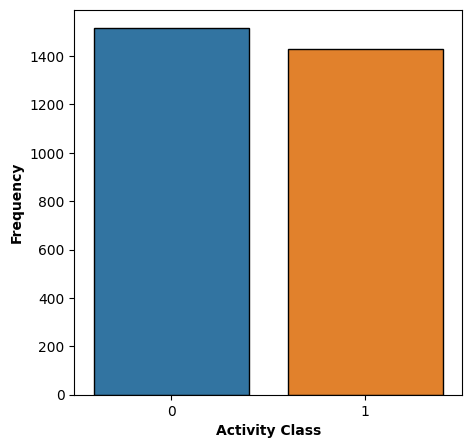

In [13]:
plt.figure(figsize=(5, 5))

sns.countplot(x="labels", data=pd.DataFrame(data=labels, columns=["labels"]), edgecolor="black")

plt.xlabel("Activity Class", fontsize=10, fontweight="bold")
plt.ylabel("Frequency", fontsize=10, fontweight="bold")
plt.show()

In [14]:
peptide_lengths = []

for peptide in df["Peptide"]:
    peptide_lengths.append(len(peptide))
    
print(len(peptide_lengths))

2947


In [15]:
df_len = pd.DataFrame(data=peptide_lengths, columns=["peptide_lengths"])

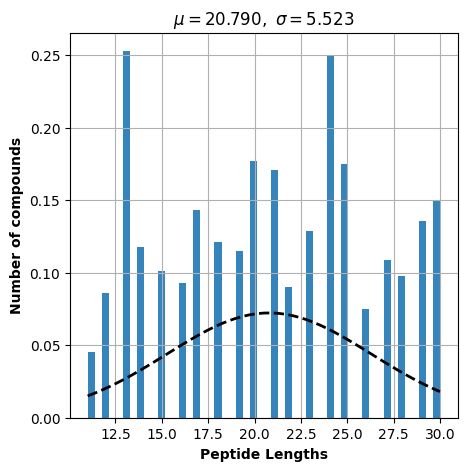

In [16]:
histogram_plot(df_len, x_axis="peptide_lengths", 
               x_label="Peptide Lengths")

### **3. Calculate Features**

#### **Amino Acid Composition**
The amino acid composition of a peptide refers to the relative abundance or percentage of each amino acid in the peptide sequence.\
Let $N_i$ be the number of occurrences of the $i_{th}$ amino acid in the peptide sequence.\
The percentage ($P_i$) of each amino acid is calculated as:

$$P_i = \frac{N_i}{len(peptide)} * 100$$

In [17]:
def calculate_amino_acid_composition(peptides: List) -> np.array:
    res = np.zeros(shape=[len(peptides), len(AMINO_ACIDS_LETTERS)])
    
    for i, peptide in enumerate(peptides):
        occs = [0] * len(AMINO_ACIDS_LETTERS)
        idcs = {AMINO_ACIDS_LETTERS[i]: i for i in range(len(AMINO_ACIDS_LETTERS))}

        for ac in peptide:
            occs[idcs[ac]] += 1

        occs = np.array(occs) / len(peptide) * 100
        res[i] = occs
        
    return res

In [18]:
acc_features = calculate_amino_acid_composition(df["Peptide"].to_numpy().flatten())
print(acc_features.shape)

(2947, 20)


In [19]:
print(acc_features[0])

[27.27272727  0.          9.09090909  0.          9.09090909  9.09090909
  0.          0.          0.          0.          0.          9.09090909
  9.09090909  0.          0.          0.          0.         18.18181818
  0.          9.09090909]


In [20]:
acc_df = pd.DataFrame(acc_features, columns=AAC_FEATURES)
acc_df.shape

(2947, 20)

In [21]:
acc_df.head()

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,27.27,0.00,9.09,0.00,9.09,9.09,0.00,0.00,0.00,0.00,0.00,9.09,9.09,0.00,0.00,0.00,0.00,18.18,0.00,9.09
1,0.00,54.55,0.00,9.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.18,18.18,0.00,0.00,0.00
2,0.00,0.00,9.09,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,0.00,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
3,0.00,0.00,0.00,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
4,0.00,0.00,9.09,18.18,18.18,9.09,0.00,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### **4. Apply ML**

#### **4.1 Dataset Preparation**

In [22]:
X, y = acc_df, df["Active"]
print(X.shape, y.shape)

(2947, 20) (2947,)


In [23]:
# remove low variance features
selection = VarianceThreshold(threshold=0.1)    
X = selection.fit_transform(X)
X.shape

(2947, 20)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

#### **4.2 Try Different ML Algorithms for Antimicrobial Activity Prediction**

In [25]:
clf = LazyClassifier(custom_metric=matthews_corrcoef)
models_train, predictions_train = clf.fit(X_train, X_train, y_train, y_train)

100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]

[LightGBM] [Info] Number of positive: 1145, number of negative: 1212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1223
[LightGBM] [Info] Number of data points in the train set: 2357, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485787 -> initscore=-0.056867
[LightGBM] [Info] Start training from score -0.056867


In [26]:
models_train

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
RandomForestClassifier,0.93,0.93,0.93,0.93,0.86,0.59
LabelSpreading,0.93,0.93,0.93,0.93,0.86,0.74
LabelPropagation,0.93,0.93,0.93,0.93,0.86,0.64
DecisionTreeClassifier,0.93,0.93,0.93,0.93,0.87,0.08
ExtraTreeClassifier,0.93,0.93,0.93,0.93,0.87,0.03
ExtraTreesClassifier,0.93,0.93,0.93,0.93,0.87,0.45
XGBClassifier,0.93,0.93,0.93,0.93,0.86,0.23
BaggingClassifier,0.92,0.92,0.92,0.92,0.84,0.19
LGBMClassifier,0.92,0.92,0.92,0.92,0.83,0.19


In [27]:
clf = LazyClassifier(custom_metric=matthews_corrcoef)
models_test, predictions_test = clf.fit(X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████| 29/29 [00:05<00:00,  5.26it/s]

[LightGBM] [Info] Number of positive: 1145, number of negative: 1212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1223
[LightGBM] [Info] Number of data points in the train set: 2357, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485787 -> initscore=-0.056867
[LightGBM] [Info] Start training from score -0.056867


In [28]:
models_test

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
NuSVC,0.75,0.76,0.76,0.75,0.51,0.38
SVC,0.75,0.76,0.76,0.75,0.51,0.35
LinearDiscriminantAnalysis,0.73,0.73,0.73,0.73,0.45,0.06
RidgeClassifier,0.73,0.73,0.73,0.73,0.45,0.02
RidgeClassifierCV,0.72,0.73,0.73,0.72,0.45,0.04
LinearSVC,0.72,0.72,0.72,0.72,0.44,0.31
CalibratedClassifierCV,0.72,0.72,0.72,0.72,0.44,1.18
KNeighborsClassifier,0.72,0.72,0.72,0.72,0.44,0.13
LogisticRegression,0.72,0.72,0.72,0.72,0.44,0.04


#### **4.3 Random Forest**

In [29]:
rf_classifier = RandomForestClassifier(random_state=0, n_estimators=500)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=0)

In [30]:
rf_classifier.score(X_train, y_train)

0.9316928298684769

In [31]:
rf_classifier.score(X_test, y_test)

0.6949152542372882

In [32]:
rf_y_pred_train = rf_classifier.predict(X_train)
rf_y_pred_test = rf_classifier.predict(X_test)

In [33]:
# Matthews correlation coefficient is a measure of the quality of binary classifications
matthews_corrcoef(y_test, rf_y_pred_test)

0.3890449290410277

In [34]:
confusion_matrix_train = confusion_matrix(y_train, rf_y_pred_train)
print(confusion_matrix_train)

[[1095  117]
 [  44 1101]]


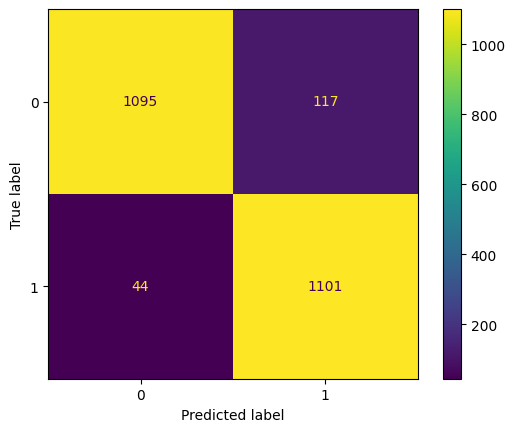

In [35]:
_ = ConfusionMatrixDisplay(confusion_matrix_train).plot()

In [36]:
confusion_matrix_test = confusion_matrix(y_test, rf_y_pred_test)
print(confusion_matrix_test)

[[216  88]
 [ 92 194]]


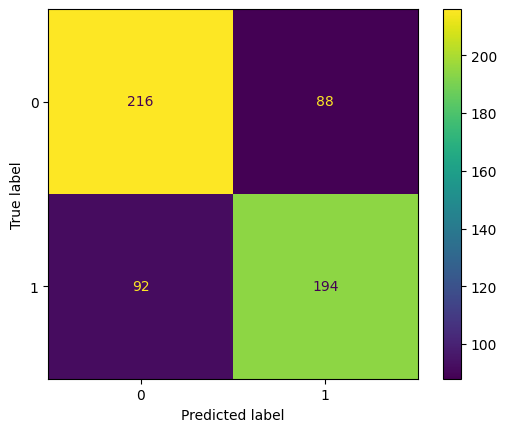

In [37]:
_ = ConfusionMatrixDisplay(confusion_matrix_test).plot()

In [38]:
model_report_train = classification_report(y_train, rf_y_pred_train, 
                                           target_names=["positive", "negative"])
print(model_report_train)

              precision    recall  f1-score   support

    positive       0.96      0.90      0.93      1212
    negative       0.90      0.96      0.93      1145

    accuracy                           0.93      2357
   macro avg       0.93      0.93      0.93      2357
weighted avg       0.93      0.93      0.93      2357



In [39]:
model_report_test = classification_report(y_test, rf_y_pred_test, 
                                          target_names=["positive", "negative"])
print(model_report_test)

              precision    recall  f1-score   support

    positive       0.70      0.71      0.71       304
    negative       0.69      0.68      0.68       286

    accuracy                           0.69       590
   macro avg       0.69      0.69      0.69       590
weighted avg       0.69      0.69      0.69       590



#### **ROC Curve**

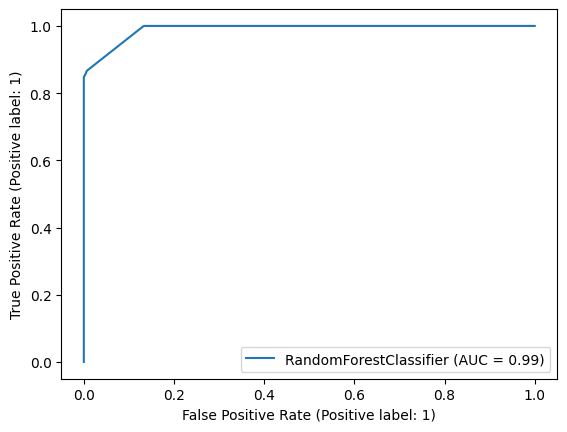

In [40]:
plot_roc_curve(rf_classifier, X_train, y_train)  
plt.show()

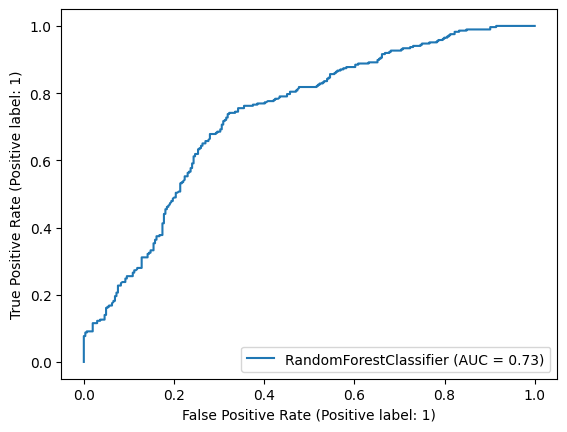

In [41]:
plot_roc_curve(rf_classifier, X_test, y_test)  
plt.show()